# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.

import datetime

### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [368]:
# path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [369]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [370]:
path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.19_미니프로젝트 6차_3_4일차_실습자료/'

#### 3) 데이터 읽어오기

In [371]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [372]:
open_data = pd.read_csv(path + file1)
weather = pd.read_csv(path + file2)

In [373]:
open_data.shape, weather.shape

((2922, 7), (4018, 7))

#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [374]:
open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [375]:
open_data

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663
...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178
2918,2022-12-28,607,5654,4648,44.8,2161,7882
2919,2022-12-29,581,5250,4247,52.5,2229,8433
2920,2022-12-30,600,5293,4200,38.3,2183,8155


In [376]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


In [377]:
weather

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [378]:
list(open_data)

['기준일', '차량운행', '접수건', '탑승건', '평균대기시간', '평균요금', '평균승차거리']

In [379]:
cols = {'기준일' : 'Date', '차량운행' : 'Cars', '접수건' : 'Submissions', 
        '탑승건' : 'Boardings', '평균대기시간' : 'Avg_wait', 
        '평균요금' : 'Avg_fare', '평균승차거리' : 'Avg_distance'}

open_data.rename(columns=cols, inplace=True)
open_data.head(2)

,Date,Cars,Submissions,Boardings,Avg_wait,Avg_fare,Avg_distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [380]:
df = open_data.copy()

In [381]:
df['Date'] = pd.to_datetime(df['Date'])

In [382]:
df['Day'] = df['Date'].dt.day # 일(숫자)
df['Weekday'] = df['Date'].dt.weekday # 요일숫자(0-월, 1-화..)
df['weekofyear'] = df['Date'].dt.weekofyear # 연 기준 몇주째(숫자)
df['Month'] = df['Date'].dt.month # 월(숫자)
df['Year'] = df['Date'].dt.year # 연(4자리 숫자)

<ipython-input-382-1341a891b2fc>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear # 연 기준 몇주째(숫자)


In [383]:
df.head()

,Date,Cars,Submissions,Boardings,Avg_wait,Avg_fare,Avg_distance,Day,Weekday,weekofyear,Month,Year
0,2015-01-01,213,1023,924,23.2,2427,10764,1,3,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,2,4,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,3,5,1,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,4,6,1,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,5,0,2,1,2015


### +++ 함수 만들기 (*별 ~~수)

In [384]:
list(df)

['Date',
 'Cars',
 'Submissions',
 'Boardings',
 'Avg_wait',
 'Avg_fare',
 'Avg_distance',
 'Day',
 'Weekday',
 'weekofyear',
 'Month',
 'Year']

In [385]:
def plot_groupby(by, kind='bar'):
    cols = ['Cars', 'Avg_wait', 'Avg_fare', 'Avg_distance', ['Submissions', 'Boardings']]
    plt.figure(figsize=(8, 6))
    for i in range(len(cols) - 1):
        plt.subplot(2, 2, i + 1)
        plt.title(cols[i])
        df.groupby([by])[cols[i]].mean().plot(kind=kind)
    plt.tight_layout()
    plt.show()
    df.groupby([by])[cols[i + 1]].mean().plot(kind=kind)
    plt.show()

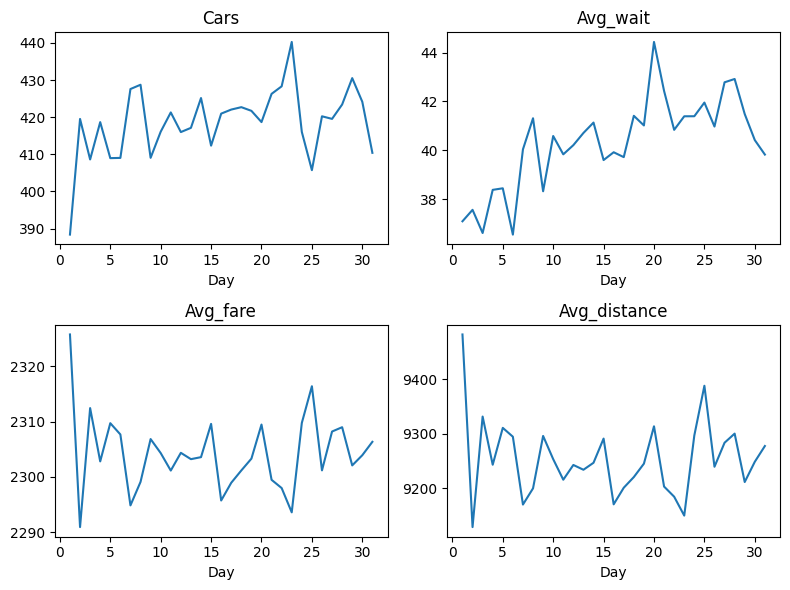

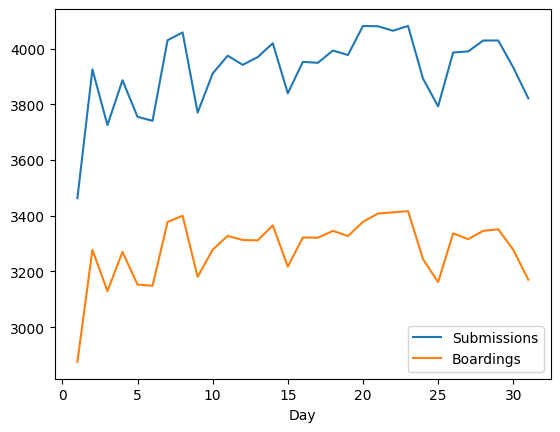

In [386]:
plot_groupby('Day', kind='line')

### (2) 일별

* 차량 운행수

In [387]:
df.groupby(['Day'])['Cars'].mean()

Day
1     388.375000
2     419.520833
3     408.614583
4     418.666667
5     408.968750
6     409.031250
7     427.583333
8     428.739583
9     409.052083
10    416.083333
11    421.281250
12    415.989583
13    417.125000
14    425.156250
15    412.333333
16    420.958333
17    422.052083
18    422.697917
19    421.708333
20    418.677083
21    426.281250
22    428.312500
23    440.260417
24    416.031250
25    405.729167
26    420.239583
27    419.541667
28    423.416667
29    430.522222
30    424.147727
31    410.392857
Name: Cars, dtype: float64

<Axes: xlabel='Day'>

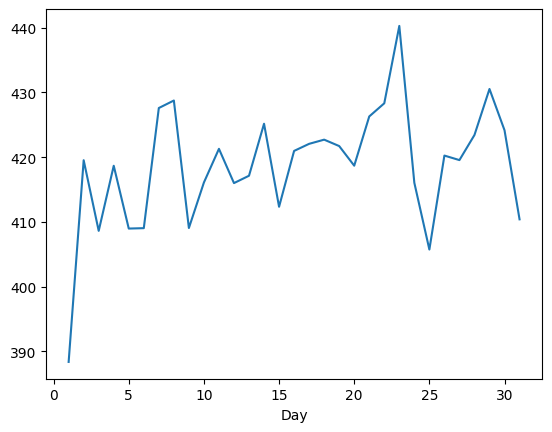

In [388]:
df.groupby(['Day'])['Cars'].mean().plot()

* 접수건, 탑승건

In [389]:
df.groupby(['Day'])[['Submissions', 'Boardings']].mean()

,Submissions,Boardings
Day,,
1,3462.656250,2875.177083
2,3925.177083,3277.520833
3,3725.281250,3129.187500
4,3886.364583,3269.989583
5,3755.000000,3153.093750
6,3740.760417,3148.364583
7,4030.062500,3377.666667
8,4058.052083,3399.833333
9,3770.041667,3180.666667


<Axes: xlabel='Day'>

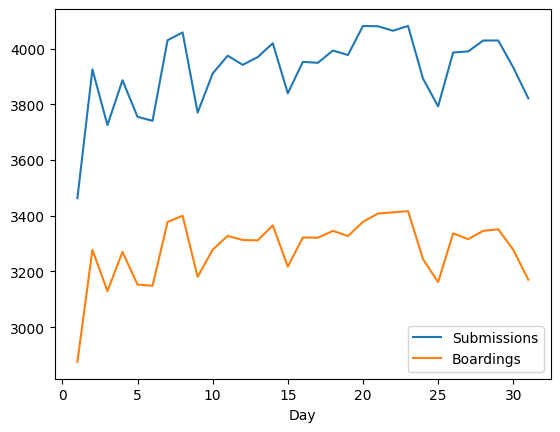

In [390]:
df.groupby(['Day'])[['Submissions', 'Boardings']].mean().plot()

* 대기시간

In [391]:
df.groupby(['Day'])['Avg_wait'].mean()

Day
1     37.095833
2     37.564583
3     36.615625
4     38.382292
5     38.445833
6     36.551042
7     40.040625
8     41.313542
9     38.325000
10    40.586458
11    39.836458
12    40.212500
13    40.711458
14    41.136458
15    39.602083
16    39.921875
17    39.721875
18    41.413542
19    41.018750
20    44.436458
21    42.431250
22    40.838542
23    41.393750
24    41.395833
25    41.955208
26    40.973958
27    42.785417
28    42.920833
29    41.486667
30    40.419318
31    39.826786
Name: Avg_wait, dtype: float64

<Axes: xlabel='Day'>

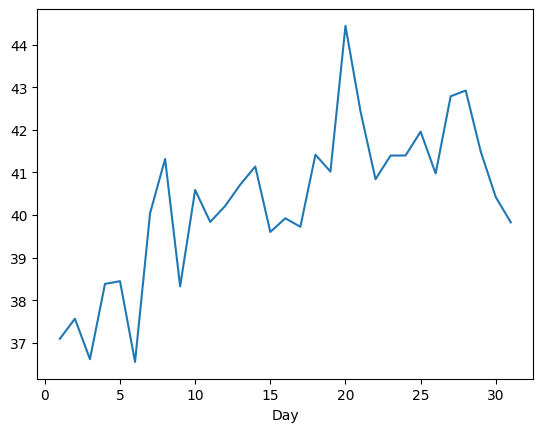

In [392]:
df.groupby(['Day'])['Avg_wait'].mean().plot()

* 운임

In [393]:
df.groupby(['Day'])['Avg_fare'].mean()

Day
1     2325.781250
2     2290.927083
3     2312.458333
4     2302.812500
5     2309.729167
6     2307.687500
7     2294.854167
8     2299.104167
9     2306.854167
10    2304.322917
11    2301.156250
12    2304.364583
13    2303.218750
14    2303.583333
15    2309.604167
16    2295.739583
17    2298.947917
18    2301.177083
19    2303.312500
20    2309.479167
21    2299.479167
22    2297.989583
23    2293.593750
24    2309.770833
25    2316.416667
26    2301.187500
27    2308.218750
28    2309.000000
29    2302.088889
30    2303.931818
31    2306.357143
Name: Avg_fare, dtype: float64

<Axes: xlabel='Day'>

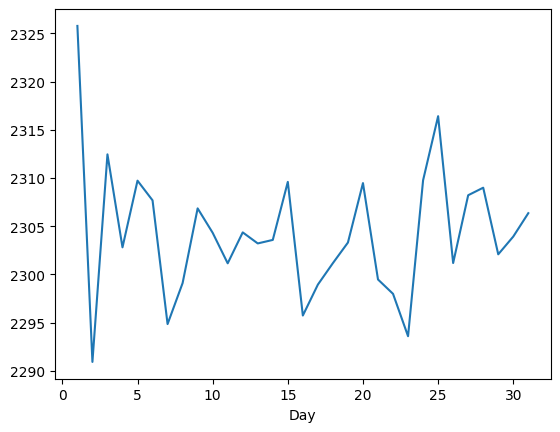

In [394]:
df.groupby(['Day'])['Avg_fare'].mean().plot()

* 이동거리

In [395]:
df.groupby(['Day'])['Avg_distance'].mean()

Day
1     9481.916667
2     9128.427083
3     9331.250000
4     9242.875000
5     9310.510417
6     9294.281250
7     9169.781250
8     9199.520833
9     9295.677083
10    9253.125000
11    9215.364583
12    9242.437500
13    9233.635417
14    9246.458333
15    9290.833333
16    9170.187500
17    9200.656250
18    9220.250000
19    9244.833333
20    9313.395833
21    9202.822917
22    9184.197917
23    9149.520833
24    9296.562500
25    9387.770833
26    9239.156250
27    9283.250000
28    9299.958333
29    9211.133333
30    9248.295455
31    9277.214286
Name: Avg_distance, dtype: float64

<Axes: xlabel='Day'>

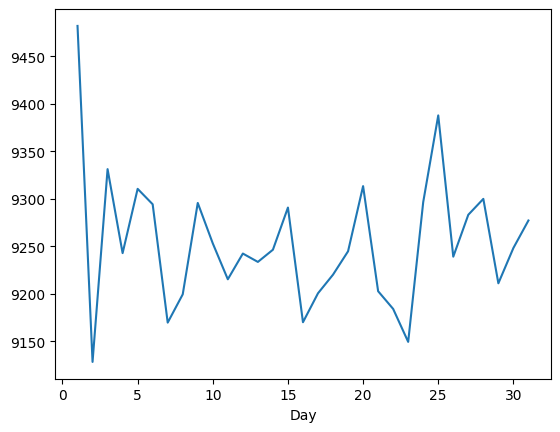

In [396]:
df.groupby(['Day'])['Avg_distance'].mean().plot()

### (3) 요일별

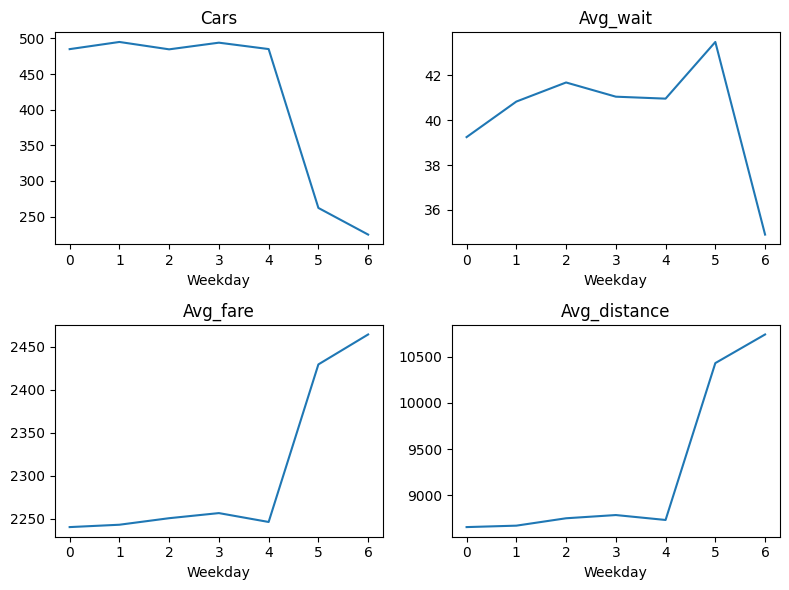

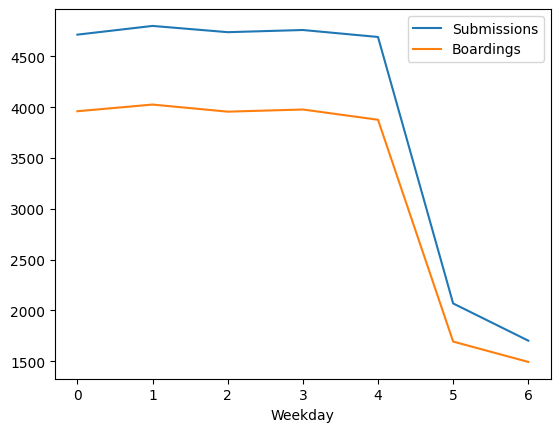

In [397]:
plot_groupby('Weekday', kind='line')

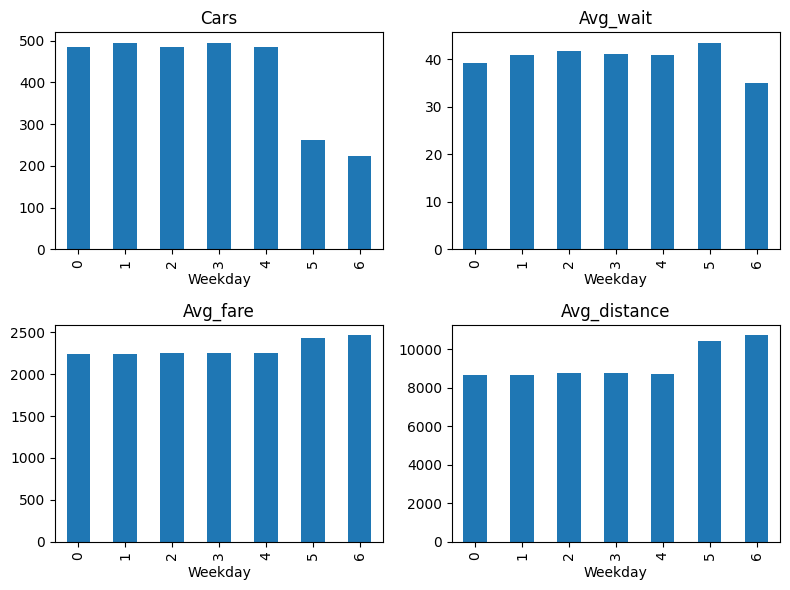

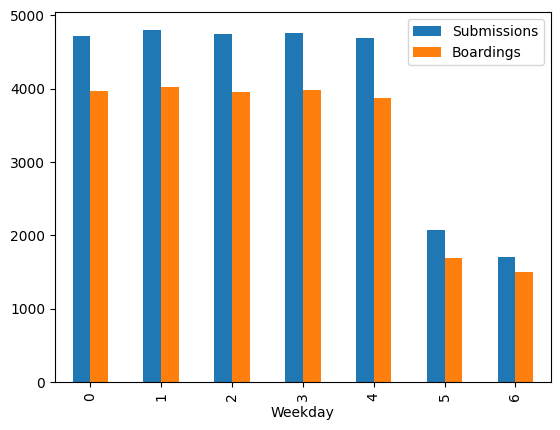

In [398]:
plot_groupby('Weekday', kind='bar')

* 차량 운행수

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (4) 월별

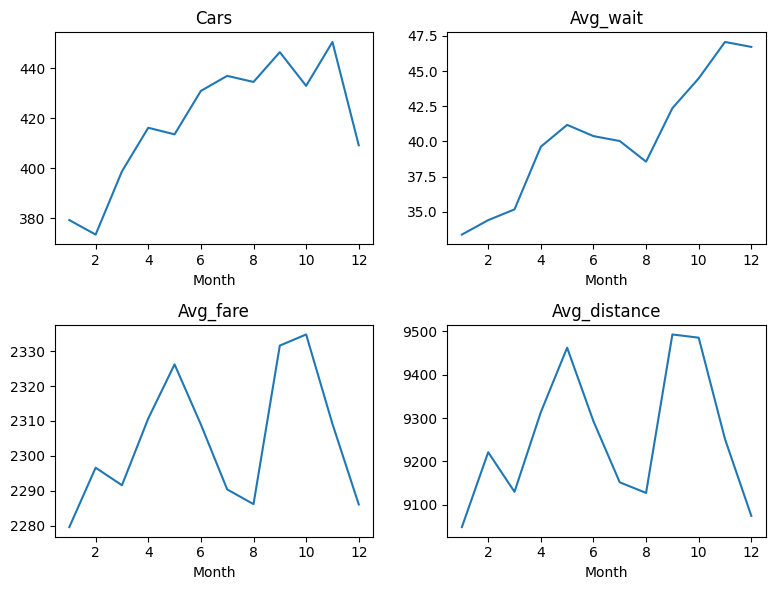

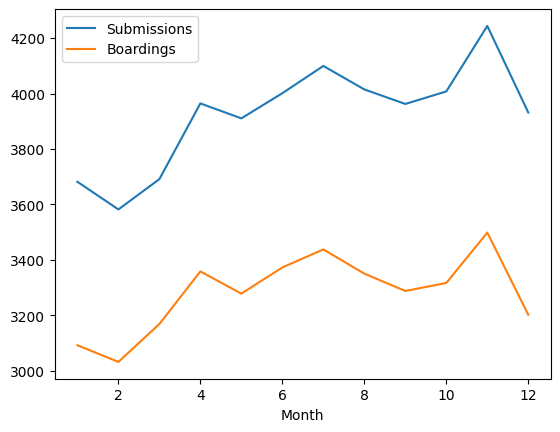

In [399]:
plot_groupby('Month', kind='line')

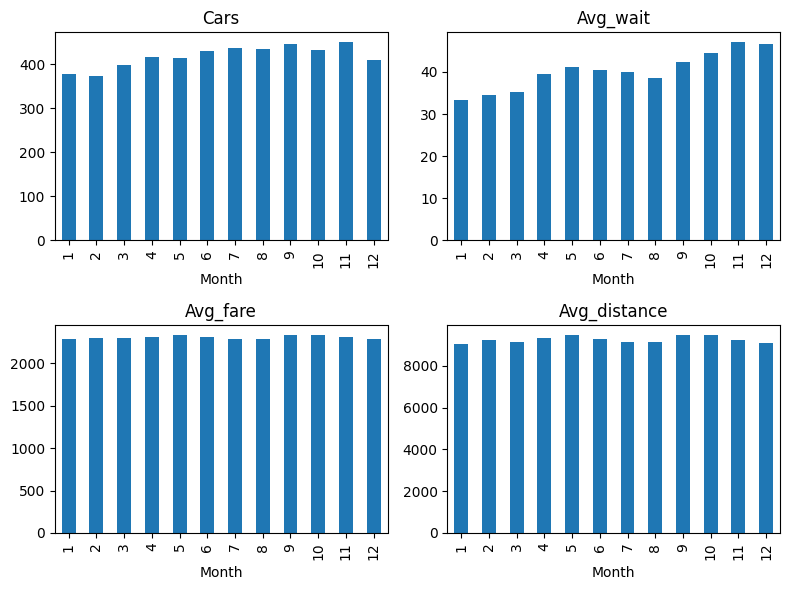

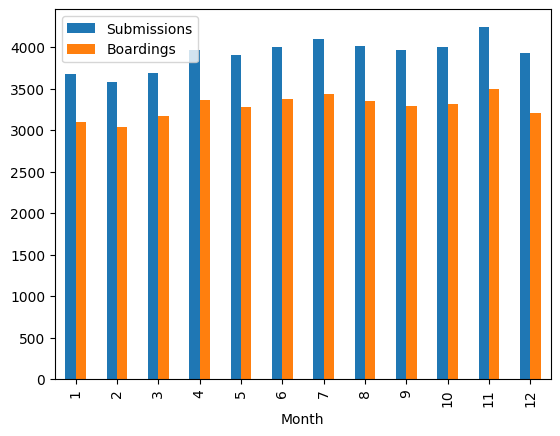

In [400]:
plot_groupby('Month', kind='bar')

* 차량 운행수

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (5) 연도별

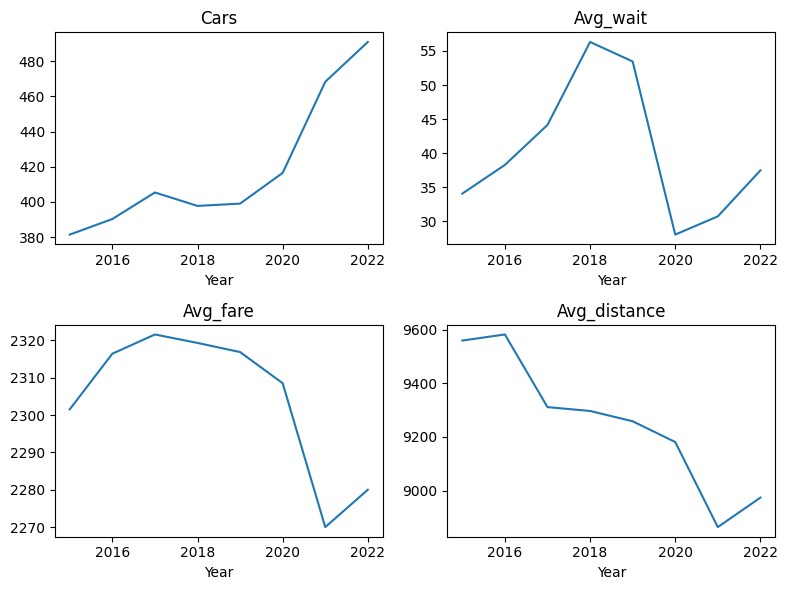

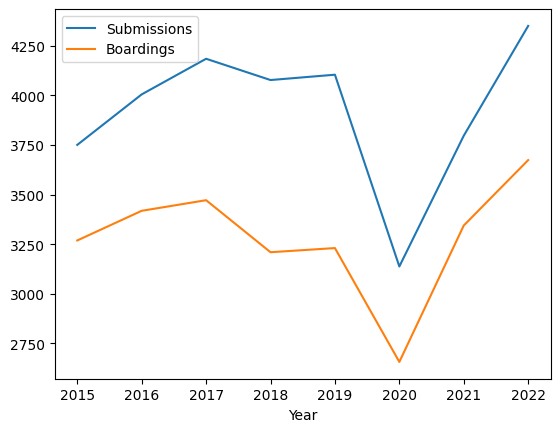

In [401]:
plot_groupby('Year', kind='line')

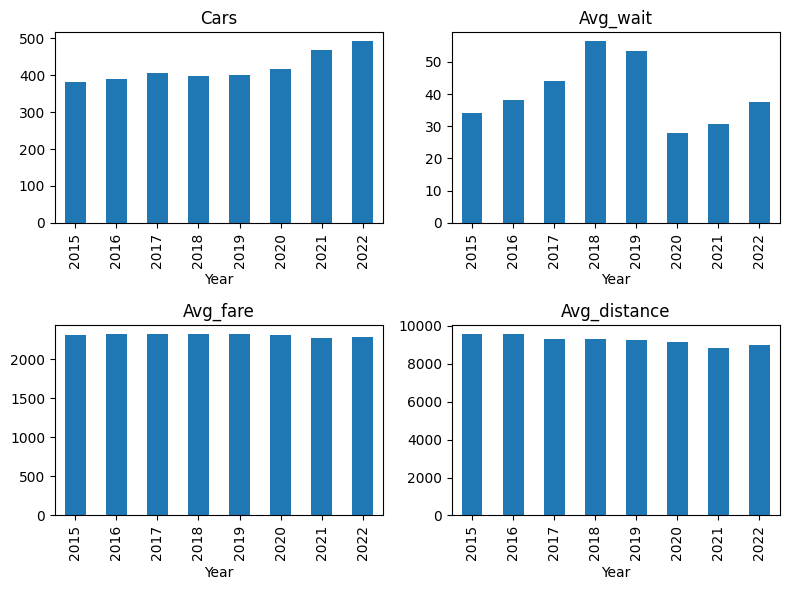

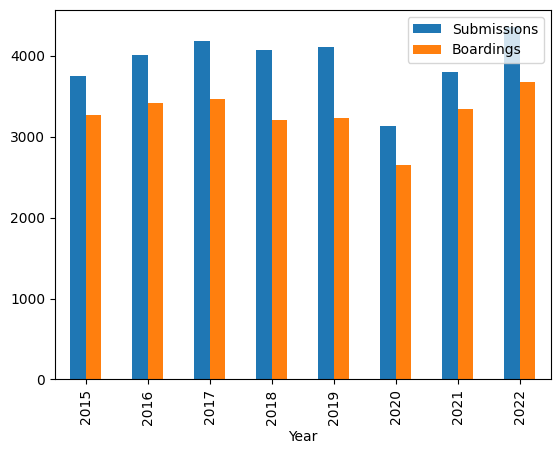

In [402]:
plot_groupby('Year', kind='bar')

* 차량 운행수

* 대기시간

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [403]:
open_data['target'] = open_data['Avg_wait'].shift(-1)

In [404]:
open_data

,Date,Cars,Submissions,Boardings,Avg_wait,Avg_fare,Avg_distance,target
0,2015-01-01,213,1023,924,23.2,2427,10764,17.2
1,2015-01-02,420,3158,2839,17.2,2216,8611,26.2
2,2015-01-03,209,1648,1514,26.2,2377,10198,24.5
3,2015-01-04,196,1646,1526,24.5,2431,10955,26.2
4,2015-01-05,421,4250,3730,26.2,2214,8663,23.6
...,...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178,44.8
2918,2022-12-28,607,5654,4648,44.8,2161,7882,52.5
2919,2022-12-29,581,5250,4247,52.5,2229,8433,38.3
2920,2022-12-30,600,5293,4200,38.3,2183,8155,33.7


### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [405]:
pd.to_datetime(weather['Date']) - datetime.timedelta(days=1)

0      2011-12-31
1      2012-01-01
2      2012-01-02
3      2012-01-03
4      2012-01-04
          ...    
4013   2022-12-26
4014   2022-12-27
4015   2022-12-28
4016   2022-12-29
4017   2022-12-30
Name: Date, Length: 4018, dtype: datetime64[ns]

In [406]:
# 날씨의 Date를 하루씩 당겨서 다음날의 날씨 예보 데이터로 사용
weather['Date'] = pd.to_datetime(weather['Date']) - datetime.timedelta(days=1)

In [407]:
open_data['Date'] = pd.to_datetime(open_data['Date'])

In [408]:
full_df = pd.merge(open_data, weather, on='Date')

In [409]:
full_df

,Date,Cars,Submissions,Boardings,Avg_wait,Avg_fare,Avg_distance,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07
1,2015-01-02,420,3158,2839,17.2,2216,8611,26.2,2.4,-9.2,0.0,73.0,37.0,8.66
2,2015-01-03,209,1648,1514,26.2,2377,10198,24.5,8.2,0.2,0.0,89.0,58.0,5.32
3,2015-01-04,196,1646,1526,24.5,2431,10955,26.2,7.9,-0.9,0.0,95.0,52.0,6.48
4,2015-01-05,421,4250,3730,26.2,2214,8663,23.6,4.1,-7.4,3.4,98.0,29.0,10.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,44.4,3.0,-7.3,0.0,86.0,51.0,10.25
2917,2022-12-27,669,5635,4654,44.4,2198,8178,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86
2918,2022-12-28,607,5654,4648,44.8,2161,7882,52.5,1.7,-7.8,0.0,71.0,34.0,10.88
2919,2022-12-29,581,5250,4247,52.5,2229,8433,38.3,2.1,-4.0,0.0,87.0,38.0,10.84


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [410]:
full_df['Weekday'] = full_df['Date'].dt.weekday # 요일 (0-월, 1-화...)
full_df['Month'] = full_df['Date'].dt.month

In [411]:
'''
봄 : 3, 4, 5
여름 : 6, 7, 8
가을 : 9, 10, 11
겨울 : 12, 1, 2
'''
result = []
for x in full_df['Month']:
    if 3 <= x <= 5:
        result.append('spring')
    elif 6 <= x <= 8:
        result.append('summer')
    elif 9 <= x <= 11:
        result.append('fall')
    else:
        result.append('winter')
full_df['Season'] = result

In [412]:
# 평일 주말
full_df['Weekend'] = np.where(full_df['Weekday'] < 5, 0, 1)

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [413]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* 간단 사용법

In [414]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [415]:
result = pd.DataFrame()
for i in range(2015, 2023):
    temp = pd.DataFrame(cal.holidays(i))
    result = pd.concat([result, temp], join='outer')

In [416]:
result

,0,1
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
...,...,...
10,2022-09-10,Midautumn Festival
11,2022-09-11,Midautumn Festival
12,2022-10-03,National Foundation Day
13,2022-10-09,Hangul Day


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [417]:
result['Holidays'] = int(1)

In [418]:
result.drop(1, axis=1, inplace=True)
result.rename(columns={0 : 'Date'}, inplace=True)

In [419]:
result['Date'] = pd.to_datetime(result['Date'])

In [420]:
result.head(2)

,Date,Holidays
0,2015-01-01,1
1,2015-02-18,1


In [421]:
full_df = pd.merge(full_df, result, on='Date', how='outer')

In [422]:
full_df['Holidays'] = full_df['Holidays'].fillna(0).astype(int)

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [423]:
full_df['Wait_MA7'] = full_df[target].rolling(7).mean()

#### 4) 탑승률

In [424]:
full_df['Boarding_percent'] = full_df['Boardings'] / full_df['Submissions']

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [425]:
full_df.isnull().sum()

Date                0
Cars                0
Submissions         0
Boardings           0
Avg_wait            0
Avg_fare            0
Avg_distance        0
target              0
temp_max            0
temp_min            0
rain(mm)            0
humidity_max(%)     0
humidity_min(%)     0
sunshine(MJ/m2)     0
Weekday             0
Month               0
Season              0
Weekend             0
Holidays            0
Wait_MA7            6
Boarding_percent    0
dtype: int64

In [426]:
# 7일 이동평균 대기시간 초기 6일 동안은 이전 데이터가 없으므로 NaN -> 제거
full_df = full_df.dropna()

In [427]:
full_df.isnull().sum()

Date                0
Cars                0
Submissions         0
Boardings           0
Avg_wait            0
Avg_fare            0
Avg_distance        0
target              0
temp_max            0
temp_min            0
rain(mm)            0
humidity_max(%)     0
humidity_min(%)     0
sunshine(MJ/m2)     0
Weekday             0
Month               0
Season              0
Weekend             0
Holidays            0
Wait_MA7            0
Boarding_percent    0
dtype: int64

In [428]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 6 to 2921
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2916 non-null   datetime64[ns]
 1   Cars              2916 non-null   int64         
 2   Submissions       2916 non-null   int64         
 3   Boardings         2916 non-null   int64         
 4   Avg_wait          2916 non-null   float64       
 5   Avg_fare          2916 non-null   int64         
 6   Avg_distance      2916 non-null   int64         
 7   target            2916 non-null   float64       
 8   temp_max          2916 non-null   float64       
 9   temp_min          2916 non-null   float64       
 10  rain(mm)          2916 non-null   float64       
 11  humidity_max(%)   2916 non-null   float64       
 12  humidity_min(%)   2916 non-null   float64       
 13  sunshine(MJ/m2)   2916 non-null   float64       
 14  Weekday           2916 n

In [429]:
# Weekday, Month, Season, Weekend, Holidays 는 범주형 데이터
cat_cols = ['Weekday', 'Month', 'Season', 'Weekend', 'Holidays']
for c in cat_cols:
    full_df[c] = full_df[c].astype('object')

<ipython-input-429-2e4a71365d82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df[c] = full_df[c].astype('object')


In [430]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 6 to 2921
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2916 non-null   datetime64[ns]
 1   Cars              2916 non-null   int64         
 2   Submissions       2916 non-null   int64         
 3   Boardings         2916 non-null   int64         
 4   Avg_wait          2916 non-null   float64       
 5   Avg_fare          2916 non-null   int64         
 6   Avg_distance      2916 non-null   int64         
 7   target            2916 non-null   float64       
 8   temp_max          2916 non-null   float64       
 9   temp_min          2916 non-null   float64       
 10  rain(mm)          2916 non-null   float64       
 11  humidity_max(%)   2916 non-null   float64       
 12  humidity_min(%)   2916 non-null   float64       
 13  sunshine(MJ/m2)   2916 non-null   float64       
 14  Weekday           2916 n

In [431]:
joblib.dump(full_df, path + 'data1.pkl')

['/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.19_미니프로젝트 6차_3_4일차_실습자료/data1.pkl']